In [167]:
#DTW calculation

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
from dtw import dtw
from numpy import array, zeros, argmin, inf, ndim
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import manhattan_distances
%matplotlib inline

In [168]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro, index_col=False)
    df      = pd.read_csv(acc,  index_col=False)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df

In [169]:
def plot_transportation_mod(transportation_mode, df):
    data = df[df['activity'] == transportation_mode][['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']][:8000]
    
    axis = data.plot(subplots = True, figsize =(20, 20), title = transportation_mode)
    
    for ax in axis:
        ax.legend(loc = 'lower left', bbox_to_anchor=(1.0,0.5))


In [170]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1

In [171]:
def Mean(df, input_features, out_feature):
    df[out_feature] = (df[input_features[0]] + df[input_features[1]]  + df[input_features[2]])/3
    
    return df
    
    

In [172]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation

def FFT(df, input_features, output_features):
   
    for i in range(len(input_features)):
        reals = np.real(np.fft.rfft(df[input_features[i]]))
        imagn = np.imag(np.fft.rfft(df[input_features[i]]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
#         complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
        df[output_features[i]] = complexs
    return df

In [173]:
def segmentation(df, N_TIME_STEPS):
    
    N_FEATURES = 1
    step = 50
    segments = []
    labels = []
    for i in range(0, len(df) - N_TIME_STEPS, step):
        gz = df['GZ'].values[i: i + N_TIME_STEPS]
        gy = df['GY'].values[i: i + N_TIME_STEPS]
    
        label = "ST"
        segments.append([gz,gy])
        labels.append(label)
    return segments, labels

In [174]:
def find_contiguous_colors(colors):
    # finds the continuous segments of colors and returns those segments
    segs = []
    curr_seg = []
    prev_color = ''
    for c in colors:
        if c == prev_color or prev_color == '':
            curr_seg.append(c)
        else:
            segs.append(curr_seg)
            curr_seg = []
            curr_seg.append(c)
        prev_color = c
    segs.append(curr_seg) # the final one
    return segs
 
def plot_multicolored_lines(x,y,colors):
    segments = find_contiguous_colors(colors)
    plt.figure(figsize=(20,4))
    start= 0
    for seg in segments:
        end = start + len(seg)
        l, = plt.gca().plot(x[start-1:end+1],y[start-1:end+1],lw=2,c=seg[0]) 
        start = end

In [175]:
def data_preprocessing(df):
    df['Milliseconds'] =df['Milliseconds']/1000 
    #apply gaussian filter with window size 5
    df = GaussianFilter(df, 5)
    
    #mean feature of 3-axis accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = 'mAcc'
    df = Mean(df, input_features, output_feature)
    
    #mean feature of 3-axis gyroscope data
    input_features = ['GX', 'GY', 'GZ']
    output_feature = 'mGyro'
    df = Mean(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series accelerometer data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fAX', 'fAY', 'fAZ']
    df = FFT(df, input_features, output_feature)
    
    #Frequency domain feature generation from time series gyroscope data
    input_features = ['AX', 'AY', 'AZ']
    output_feature = ['fGX', 'fGY', 'fGZ']
    df = FFT(df, input_features, output_feature)
    
    return df
    
    
    
    
    

In [176]:
# def graph_plot():
#     x = np.arange(337)
#     y = np.arange(337)
#     plt.figure(figsize=(200,4))
#     fig,ax = plt.subplots(1)

#     ax.plot(x,y)
#     # Get current size
#     fig_size = plt.rcParams["figure.figsize"]

#     # Prints: [8.0, 6.0]
#     print ("Current size:", fig_size)

#     # Set figure width to 12 and height to 9
#     fig_size[0] = 20
#     fig_size[1] = 4
#     plt.rcParams["figure.figsize"] = fig_size
#     plt.plot(x,y)
#     print ("Current size:", fig_size)
#     major_ticks = np.arange(0, 337, 10)
#     minor_ticks = np.arange(0, 337, 5)
#     ax.set_xticks(major_ticks)
#     ax.set_xticks(minor_ticks, minor=True)

#     plt.grid(True)

In [258]:
# Function to map the colors as a list from the input list of x variables
def pltcolor(lst):
    cols=[]
    colors = {'ST':'blue', 'LT':'red','RT':'green'}
    for l in lst:
        cols.append(colors[l])      
    return cols

In [248]:
def dtw(x, y, dist, warp=1):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.
    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure
    :param int warp: how many shifts are computed.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]  # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            min_list = [D0[i, j]]
            for k in range(1, warp + 1):
                i_k = min(i + k, r - 1)
                j_k = min(j + k, c - 1)
                min_list += [D0[i_k, j], D0[i, j_k]]
            D1[i, j] += min(min_list)
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return D1[-1, -1] / sum(D1.shape), C, D1, path

In [249]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while (i > 0) or (j > 0):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if tb == 0:
            i -= 1
            j -= 1
        elif tb == 1:
            i -= 1
        else:  # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [250]:
def loss_for_segments(segments, comp, dist_fun):
    loss =[]
    length = len(segments)
    for i in range(length):
        x = segments[i][0]
        dist, cost, acc, path = dtw(x, y, dist_fun)
        print(i , '=>', dist)
        loss.append(dist)
        
    return loss
    

In [251]:
#data for car

acc_file = 'data/car/2018-08-17_16-45-30/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-45-30/Gyroscope.csv'

df_car = read_csv_file(acc_file, gyro_file, 'car')
n = len(df_car)
print("shape -", df_car.shape)

df_car = df_car[500 : n-1000]

df_car.reset_index(drop = True, inplace = True)
df_car = data_preprocessing(df_car)
print("shape -", df_car.shape)
df_car.head()


shape - (6770, 8)
shape - (5270, 16)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,10.000,-0.168093,-0.086874,-0.021763,0.004831,0.017513,-0.016174,car,-0.092244,0.002057,58.289151,-621.349878,172.878952,58.289151,-621.349878,172.878952
1,10.021,-0.176090,-0.086792,-0.023269,0.005275,0.016239,-0.016226,car,-0.095384,0.001763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10.040,-0.190770,-0.086690,-0.025381,0.006115,0.013817,-0.016320,car,-0.100947,0.001204,56.052535,30.600307,51.303988,56.052535,30.600307,51.303988
3,10.060,-0.209879,-0.086973,-0.026831,0.007288,0.010504,-0.016440,car,-0.107894,0.000451,-137.205151,213.243329,-49.202899,-137.205151,213.243329,-49.202899
4,10.080,-0.230527,-0.087821,-0.025807,0.008688,0.006645,-0.016562,car,-0.114718,-0.000410,-275.436994,-174.310494,34.990377,-275.436994,-174.310494,34.990377


In [252]:
#data for car

acc_file = 'data/car/2018-08-17_16-50-00/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-50-00/Gyroscope.csv'

df_car1 = read_csv_file(acc_file, gyro_file, 'car')
n = len(df_car1)
print("shape -", df_car1.shape)

df_car1 = df_car1[500 : n-1000]

df_car1.reset_index(drop = True, inplace = True)
df_car1 = data_preprocessing(df_car1)
print("shape -", df_car1.shape)
df_car1.head()


shape - (13444, 8)
shape - (11944, 16)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,10.001,-0.207097,0.023341,0.433068,0.029844,0.011396,0.010114,car,0.083104,0.017118,105.045426,-1564.429410,258.415059,105.045426,-1564.429410,258.415059
1,10.022,-0.199193,0.021098,0.441693,0.029582,0.012391,0.010054,car,0.087866,0.017342,-53.510546,-131.394457,118.090230,-53.510546,-131.394457,118.090230
2,10.041,-0.184567,0.016624,0.457205,0.028997,0.014314,0.009943,car,0.096421,0.017751,12.794888,128.248785,11.645387,12.794888,128.248785,11.645387
3,10.061,-0.165156,0.009891,0.476521,0.027980,0.017020,0.009795,car,0.107085,0.018265,83.598762,326.529891,-116.715395,83.598762,326.529891,-116.715395
4,10.081,-0.143372,0.000851,0.495552,0.026401,0.020288,0.009634,car,0.117677,0.018775,-40.003710,-0.121650,35.879336,-40.003710,-0.121650,35.879336


In [253]:
print("shape -", df_car.shape)
print("shape -", df_car1.shape)

df = pd.concat([df_car, df_car1])
df.reset_index(drop = True, inplace = True)
n = len(df)
print("shape -", df.shape)
df.head()

shape - (5270, 16)
shape - (11944, 16)
shape - (17214, 16)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,mAcc,mGyro,fAX,fAY,fAZ,fGX,fGY,fGZ
0,10.000,-0.168093,-0.086874,-0.021763,0.004831,0.017513,-0.016174,car,-0.092244,0.002057,58.289151,-621.349878,172.878952,58.289151,-621.349878,172.878952
1,10.021,-0.176090,-0.086792,-0.023269,0.005275,0.016239,-0.016226,car,-0.095384,0.001763,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10.040,-0.190770,-0.086690,-0.025381,0.006115,0.013817,-0.016320,car,-0.100947,0.001204,56.052535,30.600307,51.303988,56.052535,30.600307,51.303988
3,10.060,-0.209879,-0.086973,-0.026831,0.007288,0.010504,-0.016440,car,-0.107894,0.000451,-137.205151,213.243329,-49.202899,-137.205151,213.243329,-49.202899
4,10.080,-0.230527,-0.087821,-0.025807,0.008688,0.006645,-0.016562,car,-0.114718,-0.000410,-275.436994,-174.310494,34.990377,-275.436994,-174.310494,34.990377


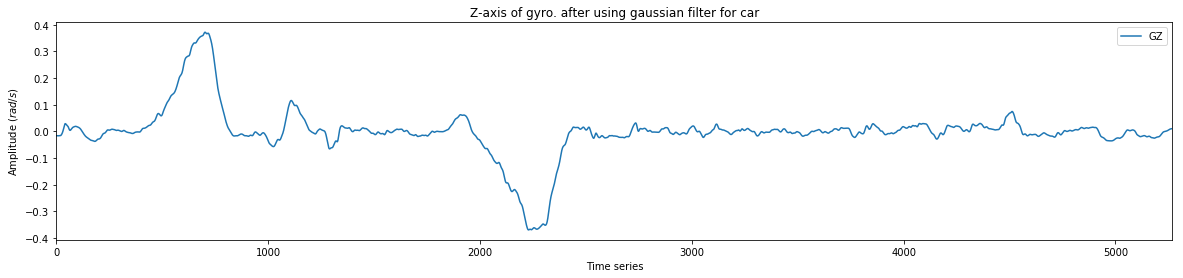

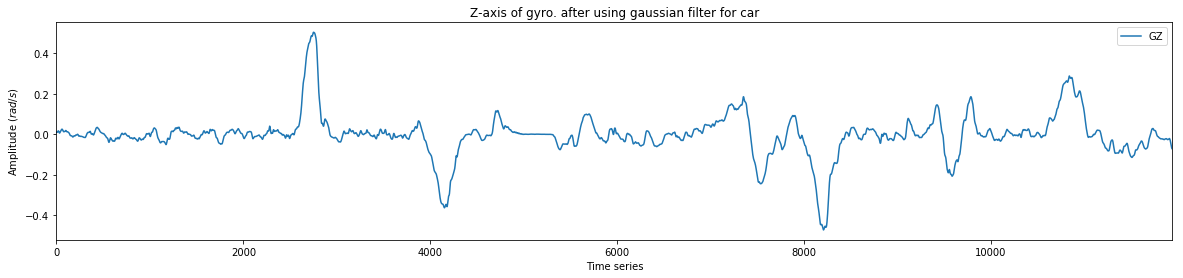

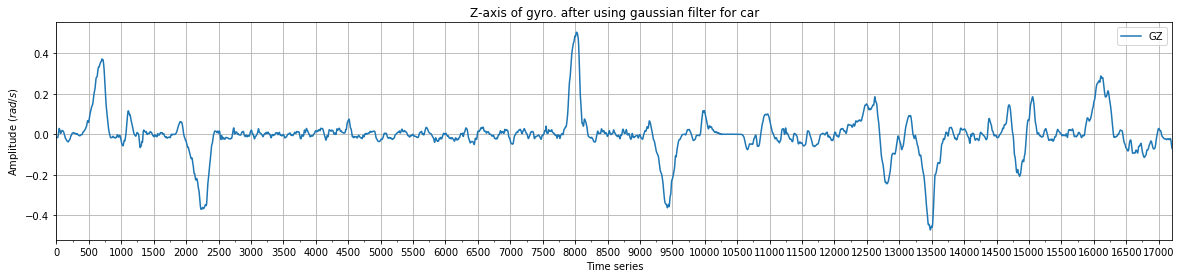

In [254]:
df_car[['GZ']].plot(figsize = (20,4), title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

df_car1[['GZ']].plot(figsize = (20,4), title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')

fig, ax = plt.subplots()
df[['GZ']].plot(figsize = (20,4),ax=ax, title = "Z-axis of gyro. after using gaussian filter for car")
plt.xlabel('Time series')
plt.ylabel('Amplitude ($rad/s$)')
major_ticks = np.arange(0, n, 500)
minor_ticks = np.arange(0, n, 250)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

plt.grid(True)

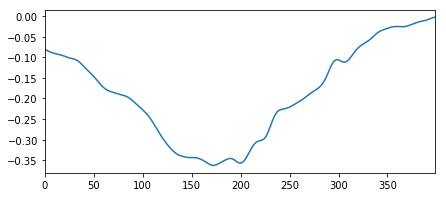

In [255]:
x = car_segments[185][0]
xx = pd.Series(x)
xx.plot(figsize = (7,3))

In [256]:
car_segments, car_labels = segmentation(df, 400)
np.array(car_segments).shape
car_labels[5:13] = ["LT"] * (13-5)
car_labels[45:37] = ["RT"] * (47-37)
car_labels[152:160] = ["LT"] * (160-152)car_segments[185][0]
car_labels[188:180] = ["RT"] * (188-180)
car_labels[270:260] = ["RT"] * (270-260)
car_labels[295:290] = ["RT"] * (295-290)
car_labels[319:314] = ["LT"] * (318-314)


In [257]:
dist_fun = manhattan_distances
y = car_segments[185][0]
diff_wrt_LT = loss_for_segments(car_segments, y ,dist_fun)

0 => 0.084775160663
1 => 0.0836957810994
2 => 0.0839136407018
3 => 0.0887496538132
4 => 0.104163195815
5 => 0.132605175813
6 => 0.153761736391
7 => 0.174519951942
8 => 0.184591197881
9 => 0.183867119887
10 => 0.179578221838
11 => 0.171810072419
12 => 0.159569871497
13 => 0.141386622163
14 => 0.117508688328
15 => 0.0993527411021
16 => 0.0905529459528
17 => 0.0873716184996
18 => 0.0864542313273
19 => 0.0856434541124
20 => 0.0838144791029
21 => 0.0944074996435
22 => 0.0895862305598
23 => 0.0796097216034
24 => 0.073503446131
25 => 0.0700244414673
26 => 0.0698388277562
27 => 0.093030687599
28 => 0.0911259014918
29 => 0.0898596177195
30 => 0.0908275933925
31 => 0.0938491084608
32 => 0.0937787795398
33 => 0.095834972353
34 => 0.0866179560306
35 => 0.0732553045006
36 => 0.0684347397334
37 => 0.0704446695373
38 => 0.0672900162309
39 => 0.0284705805545
40 => 0.00437303299725
41 => 0.00122372900153
42 => 0.00404970754548
43 => 0.011805565902
44 => 0.0213958428661
45 => 0.0332935123324
46 => 0.031

Text(0,0.5,'Difference/Loss')

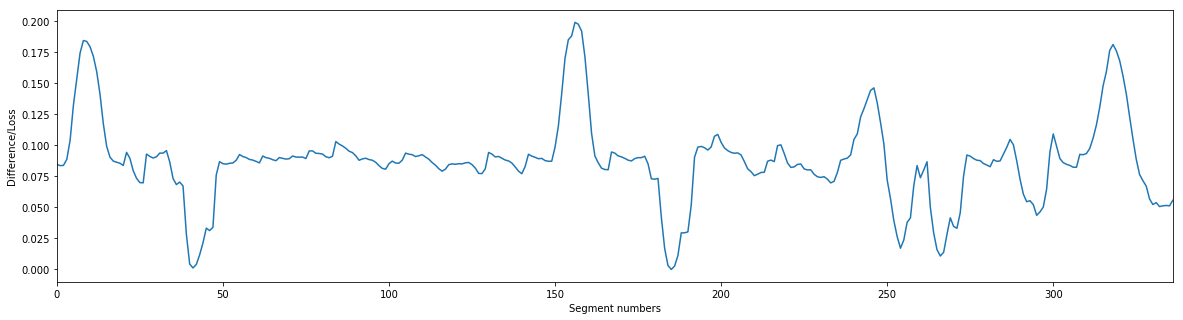

In [260]:
car_colors = pltcolor(car_labels)

loss_series = pd.Series(diff_wrt_LT)
loss_series.plot(figsize=(20,5))
plt.xlabel('Segment numbers')
plt.ylabel('Difference/Loss')


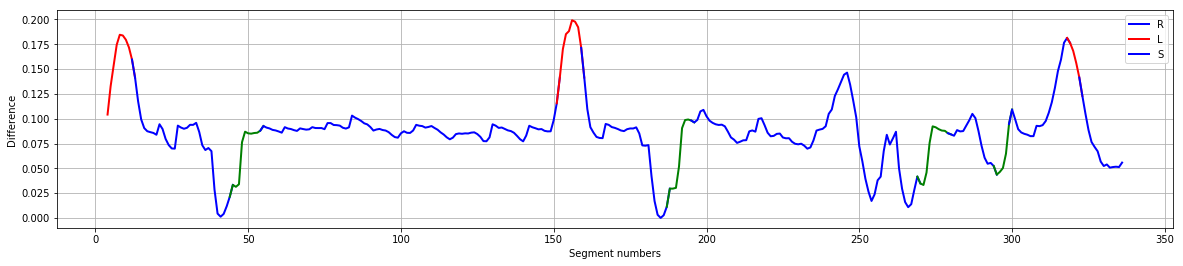

In [263]:
loss_series = pd.Series(diff_wrt_LT)

y = loss_series
x = np.arange(len(y))
plot_multicolored_lines(x,y,car_colors)
plt.xlabel('Segment numbers')
plt.ylabel('Difference')
plt.legend("RLS")
plt.grid(True)
plt.show()